In [1]:
import torch
import copy
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F

from collections import OrderedDict

import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_dataset = datasets.MNIST(root='C:/Users/WorkStation/Desktop/Git_Repositories/Dataset', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='C:/Users/WorkStation/Desktop/Git_Repositories/Dataset', train = False, transform = transforms.ToTensor(), download = True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


##### **Functions(for all)**

In [3]:
def load_data(args):    
    ldt = pd.read_csv(f"FL(mining_data)/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(train_dataset, args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

def list_np_tensor(param_data):
    data = np.concatenate((param_data['net.0.weight'].cpu().numpy(),np.expand_dims(param_data['net.0.bias'].cpu().numpy(), axis=1)),axis=1)
    data = torch.Tensor(data)
    return data

def plot_loss(FL_round_loss, FL_round_acc, round_losses, round_acces, avg_round_losses, avg_round_acces):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1,2,1)
    plt.plot(FL_round_loss, label = 'FL')
    plt.plot(round_losses, label = 'FL+AE')
    plt.plot(avg_round_losses, label = 'FL+AE(w_avg)')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(FL_round_acc, label = 'FL')
    plt.plot(round_acces, label = 'FL+AE')
    plt.plot(avg_round_acces, label = 'FL+AE(w_avg)')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()

##### **Model**

In [4]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(7851, 785),
                                    nn.ReLU(),
                                    nn.Linear(785, 50),
                                    nn.ReLU(),
                                    nn.Linear(50, self.hidden_dim)
                                    )
            
    def forward(self, x):
        output = self.encoder(x)
        return output


class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 50),
                                    nn.ReLU(),
                                    nn.Linear(50, 785),
                                    nn.ReLU(),
                                    nn.Linear(785, 7851)
                                    )
            
    def forward(self, x):
        output = self.decoder(x)
        return output
        

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(28*28, 10)
                                )

    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.net(x)
        return out

##### **FL Functions**

In [5]:
def FL_define_client(partition, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = Net().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

def FL_train(net, train_loader, criterion, optimizer, args):

    for epoch in range(args.num_epochs):        
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

    torch.save(net, args.NET_PATH)
    return net

def FL_Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]

        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model

def FL_test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()
        
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0
    round_accuracy = 0
    round_loss = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    round_loss = loss / len(test_loader)
    round_accuracy = (correct / total) * 100.0
    
    return round_loss, round_accuracy

In [6]:
def FL_experiment(partition, args):
    model = Net().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    round_acces = []

    for r in range(args.num_rounds):
        client_model_list = []
        
        for num in range(args.num_clients):
            setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = FL_define_client(partition, r, num, args)
            net = FL_train(net, train_loader, criterion, optimizer, args)
            client_model_list.append(net)

        model = FL_Fed_AVG(model, client_model_list, args)
        round_loss, round_acc = FL_test(model, partition, criterion, args)

        if r%50 == 0 or r==(args.num_rounds-1):
            print(f'[Round {r}]  Round Loss: {round_loss}  Round Acc: {round_acc:.2f}')

        round_losses.append(round_loss)
        round_acces.append(round_acc)
        
    return round_losses, round_acces

##### **FL+AE Functions**

In [7]:
def define_client(partition, global_weights, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = Net().to(device)

    else:
        net = Net().to(device)        
        net.load_state_dict(global_weights)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

def train(net, train_loader, criterion, optimizer, args):
    net.train()

    for epoch in range(args.num_epochs):        
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
    return net

def client_encode(net, r, encoder):
    round_tensor = torch.tensor(r).view(-1, 1).to(device)

    param_data = copy.deepcopy(net.state_dict())
    tensor_data = list_np_tensor(param_data).view(-1,7850).to(device)
    dt_r = torch.cat((tensor_data, round_tensor), dim=1)
    encoded_data = encoder(dt_r)
    return encoded_data

def Dec_Fed_AVG(model, decoder, client_enc_data_list, args):
    model.train()
    decoded_data_list = []
    global_weights = OrderedDict()

    for i in range(args.num_clients):
        client_enc_data_list[i] = client_enc_data_list[i].to(device)
        out = decoder(client_enc_data_list[i])[:,:-1].view((-1, 785)).cpu().detach().numpy()    
        decoded_data_list.append(out)

    w_avg = np.mean(decoded_data_list, axis=0)
    global_weights['net.0.weight'] = torch.tensor(w_avg[:,:784]).clone().detach()
    global_weights['net.0.bias'] = torch.tensor(w_avg[:,784:].squeeze()).clone().detach()

    model.load_state_dict(global_weights)

    return model, global_weights

def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()
        
    correct = 0 
    total = 0 
    loss = 0
    round_accuracy = 0
    round_loss = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    round_loss = loss / len(test_loader)
    round_accuracy = (correct / total) * 100.0
    
    return round_loss, round_accuracy

In [8]:
def experiment(partition, args):
    encoder = Encoder(args.hidden_dim)
    decoder = Decoder(args.hidden_dim)
    model = Net()
    encoder.load_state_dict(torch.load(args.enc_path))
    decoder.load_state_dict(torch.load(args.dec_path))

    encoder, decoder, model = encoder.to(device), decoder.to(device), model.to(device)
    
    global_weights = OrderedDict()
    round_losses = []
    round_acces = []


    for r in range(args.num_rounds):
        client_enc_data_list = []

        for num in range(args.num_clients):
            net, train_loader, criterion, optimizer = define_client(partition, global_weights, r, num, args)
            net = train(net, train_loader, criterion, optimizer, args)
            client_enc_data = client_encode(net, r, encoder)
            client_enc_data_list.append(client_enc_data)

        model, global_weights = Dec_Fed_AVG(model, decoder, client_enc_data_list, args)
        round_loss, round_acc = test(model, partition, criterion, args)

        if r%50 == 0 or r == (args.num_rounds-1):
            print(f'[Round: {r}]  Round Loss: {round_loss}  Round Acc: {round_acc:.2f}')

        round_losses.append(round_loss)
        round_acces.append(round_acc)
        
    return round_losses, round_acces

##### **Normal FL**

In [9]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'final'

args.num_epochs = 5
args.num_rounds = 500
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'

train_set_list = data_split(train_dataset, args)
partition = {'train':train_set_list, 'test':test_dataset}

FL_round_loss, FL_round_acc = FL_experiment(partition, args)

[Round 0]  Round Loss: 0.7766053175926209  Round Acc: 84.96
[Round 50]  Round Loss: 0.2635316574573517  Round Acc: 92.67
[Round 100]  Round Loss: 0.2630053900927305  Round Acc: 92.82
[Round 150]  Round Loss: 0.2662125315517187  Round Acc: 92.80
[Round 200]  Round Loss: 0.2698613403737545  Round Acc: 92.92
[Round 250]  Round Loss: 0.27387715376913546  Round Acc: 92.84
[Round 300]  Round Loss: 0.27760546617209914  Round Acc: 92.89
[Round 350]  Round Loss: 0.2811790708452463  Round Acc: 92.89
[Round 400]  Round Loss: 0.28480591617524625  Round Acc: 92.90
[Round 450]  Round Loss: 0.2881507502496243  Round Acc: 92.91
[Round 499]  Round Loss: 0.29114479281008243  Round Acc: 92.88


##### **[FL+AE] Non_Avg vs Avg**

===== num_data: 250 =====
avg: False
[Round: 0]  Round Loss: 0.6027184376120567  Round Acc: 86.74
[Round: 50]  Round Loss: 0.3913286290317774  Round Acc: 91.82
[Round: 100]  Round Loss: 0.8110113221406937  Round Acc: 90.89
[Round: 150]  Round Loss: 1.2458725272864104  Round Acc: 90.39
[Round: 200]  Round Loss: 1.6817125052213668  Round Acc: 90.19
[Round: 250]  Round Loss: 2.1244565853476525  Round Acc: 90.05
[Round: 300]  Round Loss: 2.5607647031545637  Round Acc: 89.93
[Round: 350]  Round Loss: 2.9951359552145003  Round Acc: 89.84
[Round: 400]  Round Loss: 3.430587523877621  Round Acc: 89.77
[Round: 450]  Round Loss: 3.874892274737358  Round Acc: 89.75
[Round: 499]  Round Loss: 4.294512631297112  Round Acc: 89.70
avg: True
[Round: 0]  Round Loss: 0.34580918356776236  Round Acc: 91.46
[Round: 50]  Round Loss: 0.32457354813814165  Round Acc: 92.56
[Round: 100]  Round Loss: 0.3371635894477367  Round Acc: 92.50
[Round: 150]  Round Loss: 0.34965009227395055  Round Acc: 92.52
[Round: 200]  

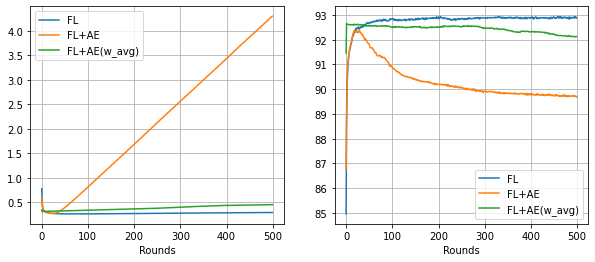

===== num_data: 500 =====
avg: False
[Round: 0]  Round Loss: 0.6126587945222854  Round Acc: 87.47
[Round: 50]  Round Loss: 0.27829297609627246  Round Acc: 92.64
[Round: 100]  Round Loss: 0.6382406275719404  Round Acc: 91.93
[Round: 150]  Round Loss: 1.2989987900853157  Round Acc: 91.43
[Round: 200]  Round Loss: 2.115843225866556  Round Acc: 91.27
[Round: 250]  Round Loss: 3.0155288276076315  Round Acc: 91.19
[Round: 300]  Round Loss: 3.9625589539878217  Round Acc: 91.10
[Round: 350]  Round Loss: 4.921709059476853  Round Acc: 91.09
[Round: 400]  Round Loss: 5.912134709358216  Round Acc: 91.03
[Round: 450]  Round Loss: 6.89060842871666  Round Acc: 91.00
[Round: 499]  Round Loss: 7.86670668721199  Round Acc: 91.02
avg: True
[Round: 0]  Round Loss: 0.2874820886552334  Round Acc: 92.07
[Round: 50]  Round Loss: 0.2898808069527149  Round Acc: 92.49
[Round: 100]  Round Loss: 0.29848434284329417  Round Acc: 92.51
[Round: 150]  Round Loss: 0.3090707437694073  Round Acc: 92.46
[Round: 200]  Round

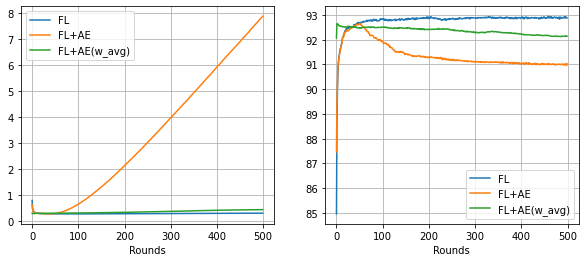

===== num_data: 1500 =====
avg: False
[Round: 0]  Round Loss: 0.654788701236248  Round Acc: 86.71
[Round: 50]  Round Loss: 0.26387546986341476  Round Acc: 92.73
[Round: 100]  Round Loss: 0.26316151723265646  Round Acc: 92.81
[Round: 150]  Round Loss: 0.2714733074977994  Round Acc: 92.69
[Round: 200]  Round Loss: 0.2890401042252779  Round Acc: 92.59
[Round: 250]  Round Loss: 0.3141197253018618  Round Acc: 92.52
[Round: 300]  Round Loss: 0.34377490133047106  Round Acc: 92.45
[Round: 350]  Round Loss: 0.3768824264407158  Round Acc: 92.33
[Round: 400]  Round Loss: 0.41235219314694405  Round Acc: 92.14
[Round: 450]  Round Loss: 0.4492748437076807  Round Acc: 92.03
[Round: 499]  Round Loss: 0.4867875980213284  Round Acc: 91.99
avg: True
[Round: 0]  Round Loss: 0.28794744580984116  Round Acc: 92.06
[Round: 50]  Round Loss: 0.2901813170313835  Round Acc: 91.85
[Round: 100]  Round Loss: 0.2914059874415398  Round Acc: 91.84
[Round: 150]  Round Loss: 0.2932267501950264  Round Acc: 91.87
[Round: 2

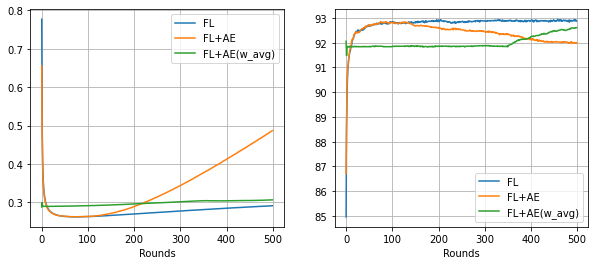

===== num_data: 2500 =====
avg: False
[Round: 0]  Round Loss: 0.6672833704948425  Round Acc: 86.96
[Round: 50]  Round Loss: 0.26395476013422015  Round Acc: 92.65
[Round: 100]  Round Loss: 0.26379477731883527  Round Acc: 92.79
[Round: 150]  Round Loss: 0.2684545589238405  Round Acc: 92.85
[Round: 200]  Round Loss: 0.289196796938777  Round Acc: 92.53
[Round: 250]  Round Loss: 0.39408182181417944  Round Acc: 89.36
[Round: 300]  Round Loss: 0.609754902869463  Round Acc: 83.66
[Round: 350]  Round Loss: 0.9278522935509682  Round Acc: 78.04
[Round: 400]  Round Loss: 1.2707439410686492  Round Acc: 73.55
[Round: 450]  Round Loss: 1.6281740671396256  Round Acc: 70.56
[Round: 499]  Round Loss: 1.9831203281879426  Round Acc: 68.53
avg: True
[Round: 0]  Round Loss: 0.3130026231706142  Round Acc: 91.62
[Round: 50]  Round Loss: 0.29077597707509995  Round Acc: 92.68
[Round: 100]  Round Loss: 0.28936475053429606  Round Acc: 92.67
[Round: 150]  Round Loss: 0.28708352722227576  Round Acc: 92.66
[Round: 2

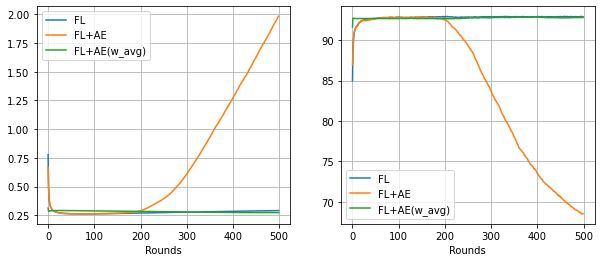

In [10]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.num_epochs = 5
args.num_rounds = 500
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100
args.hidden_dim = 15
args.num_data = 100

args.avg = False

name_var1 = 'num_data'
name_var2 = 'avg'

list_var1 = [50, 100, 300, 500]
list_var2 = [False, True]


for var1 in list_var1:
    print(f"===== {name_var1}: {var1*5} =====")
    setattr(args, name_var1, var1)

    for var2 in list_var2:
        print(f"{name_var2}: {var2}") 
        setattr(args, name_var2, var2)
  
        train_set_list = data_split(train_dataset, args)
        partition = {'train':train_set_list, 'test':test_dataset}

        if var2 == False:
            args.enc_path = f"AE_model/client = {args.num_clients}/enc_num_data_{var1}.pth"
            args.dec_path = f"AE_model/client = {args.num_clients}/dec_num_data_{var1}.pth"
            round_losses, round_acces = experiment(partition, args)

        else:
            args.enc_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/enc_num_data_{var1}.pth"
            args.dec_path = f"FL(mining_data)/w_avg_AE_model/client = {args.num_clients}/dec_num_data_{var1}.pth"
            avg_round_losses, avg_round_acces = experiment(partition, args)


    plot_loss(FL_round_loss, FL_round_acc, round_losses, round_acces, avg_round_losses, avg_round_acces)